In [1]:
import cv2
import numpy as np
import os
import time
from FPS import FPS, now
from tensorflow import keras

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,LSTM, Dense,Concatenate
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:
DATA_PATH = os.path.join('Collected_Data') 
actions = [ action for action in os.listdir(DATA_PATH)]
print('The number of actions is',len(actions))
print(actions)
no_sequences =60
sequence_length = 30
start_folder = 30
label_map = {label:num for num, label in enumerate(actions)}

The number of actions is 50
['100', 'a', 'about', 'am', 'and', 'are', 'big', 'can', 'clothes', 'cute', 'do', 'eight', 'five', 'for', 'four', 'give', 'have', 'Hello', 'I', 'in', 'is', 'it', 'look', 'my', 'name', 'nine', 'no', 'one', 'pretty', 'red', 'see', 'sell', 'send', 'seven', 'shirt', 'show', 'six', 'skirt', 'small', 'so', 'thank', 'the', 'think', 'this', 'three', 'to', 'two', 'wear', 'yes', 'you']


In [5]:
def Notused(DATA_PATH = DATA_PATH) :
    actions = [ action for action in os.listdir(DATA_PATH)]
    List = []
    for action in actions: 
        word_path = os.path.join(DATA_PATH,action)
        number = len(os.listdir(word_path))
        if number < 60 : List.append(action)
    if len(List) == 0 : print('There is no error word')
    else : return List 
Error_list = Notused(DATA_PATH)
Error_list 



There is no error word


In [6]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        res = np.load(os.path.join(DATA_PATH, action, str(action)+'_'+ str(sequence)+'.npy'))
        sequences.append(res)
        labels.append(label_map[action])

# Train Model

In [7]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],-1)
X_test = X_test.reshape(X_test.shape[0],X_train.shape[1],-1)
X_train.shape

(2400, 60, 63)

In [8]:
input = Input(shape=(60,63), name="base_input")
y = LSTM(128,return_sequences=False)(input)
x = LSTM(128,return_sequences=True)(input)
x = LSTM(256,return_sequences=False)(x)
x = Concatenate()([x,y])
x = Dense(128, activation='relu', name="first_base_dense")(x)
x = Dense(64, activation='relu', name="second_base_dense")(x)
x = Dense(50, activation='softmax')(x)
model = Model(inputs=input, outputs=x)

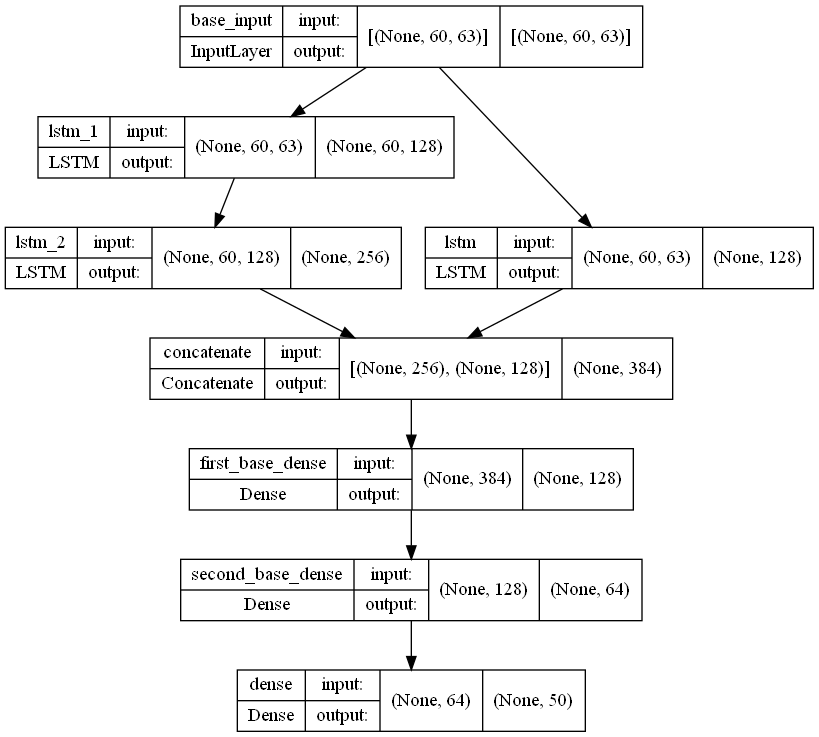

In [10]:
plot_model(model,show_shapes=True)

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(60, 63)))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 base_input (InputLayer)        [(None, 60, 63)]     0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 60, 128)      98304       ['base_input[0][0]']             
                                                                                                  
 lstm_2 (LSTM)                  (None, 256)          394240      ['lstm_1[0][0]']                 
                                                                                                  
 lstm (LSTM)                    (None, 128)          98304       ['base_input[0][0]']             
                                                                                              

In [15]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
es = EarlyStopping(monitor='val_loss',patience= 3 , min_delta = 0.01)

In [16]:
model.fit(X_train, y_train, epochs=1000,validation_data=(X_test,y_test),callbacks = [es])

Epoch 1/1000
75/75 [==============================] - 43s 497ms/step - loss: 2.9146 - categorical_accuracy: 0.2113 - val_loss: 1.7125 - val_categorical_accuracy: 0.4167
Epoch 2/1000
75/75 [==============================] - 24s 319ms/step - loss: 1.0109 - categorical_accuracy: 0.6679 - val_loss: 0.4942 - val_categorical_accuracy: 0.8550
Epoch 3/1000
75/75 [==============================] - 24s 315ms/step - loss: 0.5375 - categorical_accuracy: 0.8125 - val_loss: 0.6271 - val_categorical_accuracy: 0.7367
Epoch 4/1000
75/75 [==============================] - 25s 333ms/step - loss: 0.3950 - categorical_accuracy: 0.8700 - val_loss: 0.4142 - val_categorical_accuracy: 0.8350
Epoch 5/1000
75/75 [==============================] - 23s 307ms/step - loss: 0.2009 - categorical_accuracy: 0.9312 - val_loss: 0.2254 - val_categorical_accuracy: 0.9383
Epoch 6/1000
75/75 [==============================] - 23s 305ms/step - loss: 0.1851 - categorical_accuracy: 0.9350 - val_loss: 0.1812 - val_categorical_acc

In [17]:
res = model.predict(X_test)
model.save('action50_Custom_LSTM_1.h5')


In [18]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [19]:
yhat = model.predict(X_test)

In [20]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [22]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[586,   0],
        [  7,   7]],

       [[586,   0],
        [  0,  14]],

       [[590,   0],
        [  0,  10]],

       [[589,   0],
        [  0,  11]],

       [[591,   1],
        [  0,   8]],

       [[586,   0],
        [  4,  10]],

       [[584,   0],
        [  0,  16]],

       [[592,   2],
        [  0,   6]],

       [[589,   0],
        [  0,  11]],

       [[589,   0],
        [  0,  11]],

       [[588,   0],
        [  1,  11]],

       [[589,   0],
        [  0,  11]],

       [[581,   7],
        [  0,  12]],

       [[592,   0],
        [  0,   8]],

       [[583,   0],
        [  1,  16]],

       [[593,   0],
        [  0,   7]],

       [[588,   0],
        [  0,  12]],

       [[586,   0],
        [  0,  14]],

       [[589,   0],
        [  7,   4]],

       [[586,   0],
        [  0,  14]],

       [[583,   7],
        [  0,  10]],

       [[587,   0],
        [  0,  13]],

       [[590,   0],
        [  0,  10]],

       [[587,   0],
        [  0, 

In [23]:
accuracy_score(ytrue, yhat)


0.9466666666666667